In [317]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [318]:
# Reading Data
df_online_retail = pd.read_csv('../00_Data/data.csv', encoding= 'unicode_escape')
df_online_retail_xlsx = pd.read_excel('../00_Data/online_retail.xlsx', sheet_name=0)
df_online_retail_II = pd.read_excel('../00_Data/online_retail_II.xlsx', sheet_name=0)
df_rec_sys_order = pd.read_excel('../00_Data/Rec_sys_data.xlsx', sheet_name=0)
df_rec_sys_customer = pd.read_excel('../00_Data/Rec_sys_data.xlsx', sheet_name=1)
df_rec_sys_product = pd.read_excel('../00_Data/Rec_sys_data.xlsx', sheet_name=2)

# 1. Online Retail Dataset

## 1.1 Data Split

In [319]:
# First check Data Types 
df_online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [320]:
# Since we will use a chronological split for the train/test split, we need to convert Invoice Date to Datetime
df_online_retail['InvoiceDate'] = pd.to_datetime(df_online_retail['InvoiceDate'])
df_online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [321]:
# Check if the date column is in chronological order
is_chronological = df_online_retail['InvoiceDate'].is_monotonic_increasing

if is_chronological:
    print('The date column is in chronological order')
else:
    print('The date column is not in chronological order')

The date column is in chronological order


In [322]:
# Last but not least, we will need a column, which indicates that an item was bought by a user. We are assuming, this column is binary - 1 means bought, 0 means no interaction
df_online_retail['purchased'] = 1
df_online_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,purchased
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1


In [323]:
# Load the Chronological Splitter
from recommenders.datasets.python_splitters import python_chrono_split

In [324]:
train, test = python_chrono_split(df_online_retail, ratio=0.8, filter_by='user', min_rating=10, col_user='CustomerID', col_item='StockCode', col_timestamp='InvoiceDate')

In [325]:
# Print the number of users and items in the training and test sets
print(f'Before Split: {df_online_retail.CustomerID.nunique()} users, {df_online_retail.StockCode.nunique()} items')
print(f'Train: {train.CustomerID.nunique()} users, {train.StockCode.nunique()} items')
print(f'Test: {test.CustomerID.nunique()} users, {test.StockCode.nunique()} items')

Before Split: 4372 users, 4070 items
Train: 3781 users, 3659 items
Test: 3781 users, 3022 items


For an affinity matrix, we need the same number of unique users and items in both datasets. This will be done in the next step

In [326]:
# find the set of unique items in both the train and test sets
train_items = set(train['StockCode'].unique())
test_items = set(test['StockCode'].unique())

# find the intersection of the sets from step 1
common_items = train_items.intersection(test_items)

# filter the train and test sets to include only the rows with item IDs that are in the intersection set
train = train[train['StockCode'].isin(common_items)]
test = test[test['StockCode'].isin(common_items)]

In [327]:
# Check again, if the number of unique items and users match
print(f'Train: {train.CustomerID.nunique()} users, {train.StockCode.nunique()} items')
print(f'Test: {test.CustomerID.nunique()} users, {test.StockCode.nunique()} items')

Train: 3781 users, 3001 items
Test: 3781 users, 3001 items


In [328]:
print(train.shape)
print(test.shape)

(318382, 9)
(80732, 9)


## 1.2. Create User-Item Matrix

In [329]:
# create a pivot table from the dataframe
train_matrix = pd.pivot_table(train, values='purchased', index='CustomerID', columns='StockCode')

# replace non-zero values with 1 and missing values with 0
train_matrix[train_matrix > 0] = 1
train_matrix = train_matrix.fillna(0)

# Show Matrix
train_matrix.head()

StockCode,10002,10080,10120,10124G,10125,10133,10135,11001,15030,15034,...,90214R,90214S,90214Y,BANK CHARGES,C2,CRUK,D,DOT,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [330]:
# create a pivot table from the dataframe
test_matrix = pd.pivot_table(test, values='purchased', index='CustomerID', columns='StockCode', aggfunc=np.sum)

# replace non-zero values with 1 and missing values with 0
test_matrix[test_matrix > 0] = 1
test_matrix = test_matrix.fillna(0)

# Show Matrix
test_matrix.head()

StockCode,10002,10080,10120,10124G,10125,10133,10135,11001,15030,15034,...,90214R,90214S,90214Y,BANK CHARGES,C2,CRUK,D,DOT,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [306]:
print(train_matrix.shape)
print(test_matrix.shape)

(3781, 3001)
(3781, 3001)


## 1.3. Model

In [307]:
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

#RBM 
from recommenders.models.rbm.rbm import RBM
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

# Evaluation
from recommenders.evaluation.python_evaluation import (
    precision_at_k,
    recall_at_k,
)


In [308]:
del(model)

In [309]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(train_matrix), np.array([0])),
    visible_units=train_matrix.shape[1],
    hidden_units=5000,
    training_epoch=30,
    minibatch_size=3000,
    keep_prob=0.7,
    with_metrics=True,
    sampling_protocol=[50, 70, 80, 90, 100]
)

Took 112.39 seconds for training.


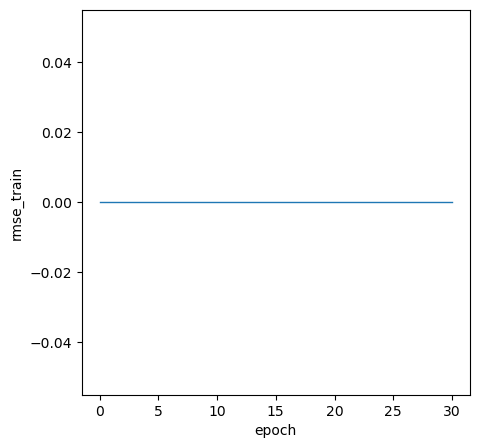

In [310]:
#Model Fit
with Timer() as train_time:
    model.fit(train_matrix)

print("Took {:.2f} seconds for training.".format(train_time.interval))

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [311]:
# number of top score elements to be recommended  
K = 10

# Model prediction on the test set Xtst.
with Timer() as prediction_time:
    top_k =  model.recommend_k_items(test_matrix)

print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Took 2.73 seconds for prediction.


In [312]:
test_pred_df = pd.DataFrame(data=top_k, index=test_matrix.index, columns=test_matrix.columns)


In [313]:
test_pred  = pd.melt(test_pred_df.reset_index(), id_vars=['CustomerID'], value_vars=test_pred_df.columns, var_name='StockCode', value_name='predictions')
test_true =  pd.melt(test_matrix.reset_index(), id_vars=['CustomerID'], value_vars=test_matrix.columns, var_name='StockCode', value_name='purchased')

In [314]:
#collection of evaluation metrics for later use
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):
    eval_precision = precision_at_k(data_true, data_pred, col_user="CustomerID", col_item="StockCode", 
                                col_rating="purchased", col_prediction="predictions", 
                                relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="CustomerID", col_item="StockCode", 
                            col_rating="purchased", col_prediction="predictions", 
                            relevancy_method="top_k", k= K)


    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )

    return df_result

In [315]:
eval_100k = ranking_metrics(
    data_size="Online Retail",
    data_true=test_true,
    data_pred=test_pred,
    K=10
)

eval_100k

,Dataset,K,Precision@k,Recall@k
0,Online Retail,10,1.0,0.003332
